<a href="https://colab.research.google.com/github/shizakhurram/LandClassification/blob/main/GIS_Classification_Construction_Land.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
data_path = "/content/drive/MyDrive/hyperspectral_data/constructionland.zip"
!unzip {data_path} -d /content/drive/MyDrive/hyperspectral_data/

Archive:  /content/drive/MyDrive/hyperspectral_data/constructionland.zip
   creating: /content/drive/MyDrive/hyperspectral_data/constructionland/
   creating: /content/drive/MyDrive/hyperspectral_data/constructionland/city_building/
  inflating: /content/drive/MyDrive/hyperspectral_data/constructionland/city_building/city_building(1).tif  
  inflating: /content/drive/MyDrive/hyperspectral_data/constructionland/city_building/city_building(10).tif  
  inflating: /content/drive/MyDrive/hyperspectral_data/constructionland/city_building/city_building(100).tif  
  inflating: /content/drive/MyDrive/hyperspectral_data/constructionland/city_building/city_building(1000).tif  
  inflating: /content/drive/MyDrive/hyperspectral_data/constructionland/city_building/city_building(1001).tif  
  inflating: /content/drive/MyDrive/hyperspectral_data/constructionland/city_building/city_building(1002).tif  
  inflating: /content/drive/MyDrive/hyperspectral_data/constructionland/city_building/city_building(1

In [ ]:
EXTRACTED_DATA_PATH = "/content/drive/MyDrive/hyperspectral_data/constructionland"
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
BATCH_SIZE = 32
EPOCHS = 3

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

full_dataset = datasets.ImageFolder(root=EXTRACTED_DATA_PATH, transform=transform)
class_names = full_dataset.classes
print(f"Classes found: {class_names}")

Classes found: ['city_building', 'container', 'residents', 'storage_room']


In [ ]:
class_counts = []
for dir in os.listdir(EXTRACTED_DATA_PATH):
  class_counts.append(len(os.listdir(os.path.join(EXTRACTED_DATA_PATH, dir))))

<ipython-input-8-a5ce7d6f2e3d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts, palette='viridis')


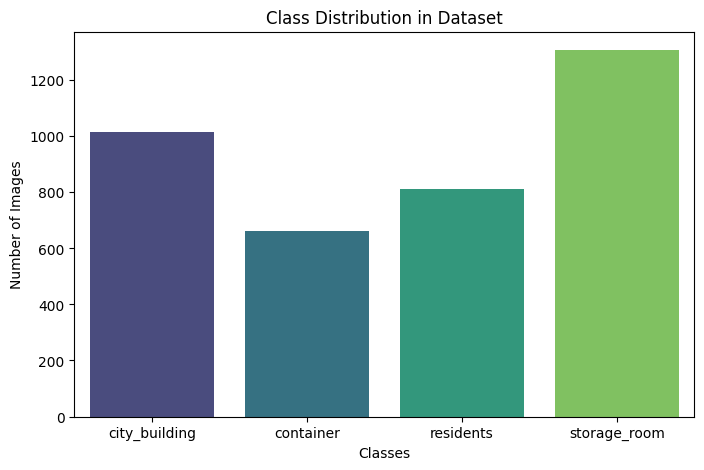

In [ ]:

def plot_class_distribution(dataset, class_names):

    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_names, y=class_counts, palette='viridis')
    plt.title("Class Distribution in Dataset")
    plt.ylabel("Number of Images")
    plt.xlabel("Classes")
    plt.show()

plot_class_distribution(full_dataset, class_names)

In [ ]:
total_size = len(full_dataset)
train_size = int(TRAIN_SIZE * total_size)
val_size = int(VAL_SIZE * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [ ]:
batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
model = CNNClassifier(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 🎯 Training and validation function
def train_model(model, criterion, optimizer, train_loader, val_loader, model_name, epochs=EPOCHS):
    best_val_acc = 0.0
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []
    for epoch in range(epochs):
        print(epoch)
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        train_acc_list.append(train_acc)
        train_loss_list.append(total_loss / len(train_loader))

        val_acc, val_loss = evaluate_model(model, val_loader, criterion)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_model_{model_name}.pth')

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list



In [ ]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct, total, total_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total, total_loss / len(data_loader)





In [ ]:
# 📊 Confusion Matrix visualization
def analyze_model(model, data_loader, model_name):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title(f"Normalized Confusion Matrix - {model_name}")
    plt.show()



In [ ]:
# 🏃‍♂️ Plot training analysis
def plot_training_analysis(train_acc, val_acc, train_loss, val_loss, model_name):
    epochs = range(1, len(train_acc) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(epochs, train_acc, 'bo-', label='Training Acc')
    axs[0].plot(epochs, val_acc, 'ro-', label='Validation Acc')
    axs[0].set_title(f'{model_name}: Accuracy per Epoch')
    axs[0].legend()

    axs[1].plot(epochs, train_loss, 'bo-', label='Training Loss')
    axs[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
    axs[1].set_title(f'{model_name}: Loss per Epoch')
    axs[1].legend()

    plt.show()

In [ ]:
def get_pretrained_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'densenet121':
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Freeze feature extractor
    for param in model.parameters():
        param.requires_grad = False

    # Only classifier layers are trainable
    for param in model.fc.parameters() if hasattr(model, 'fc') else model.classifier.parameters():
        param.requires_grad = True

    return model.to(device)


🚀 Training model: custom
0
Epoch [1/3] - Loss: 76.9343 - Train Acc: 0.6027 - Val Acc: 0.8433
1
Epoch [2/3] - Loss: 37.8577 - Train Acc: 0.8334 - Val Acc: 0.9261
2
Epoch [3/3] - Loss: 25.8343 - Train Acc: 0.8986 - Val Acc: 0.9278


<ipython-input-21-94ed3bc2314c>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model_name}.pth'))


✅ Test Accuracy (custom): 0.9140


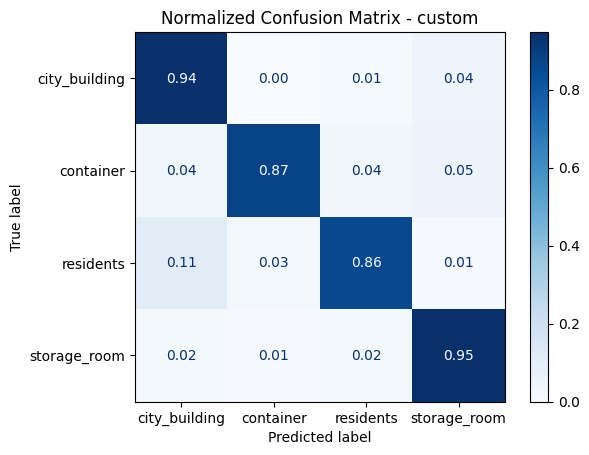

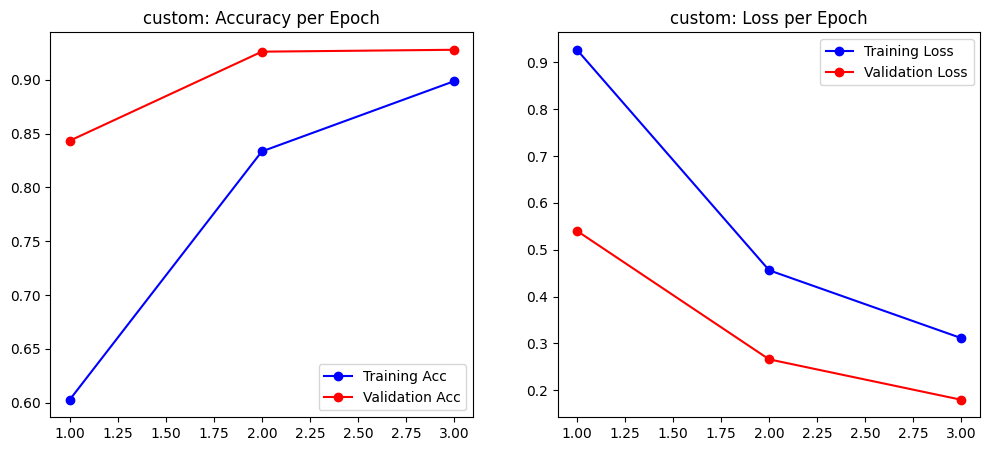


🚀 Training model: densenet121


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 78.2MB/s]


0
Epoch [1/3] - Loss: 41.5073 - Train Acc: 0.8515 - Val Acc: 0.9665
1
Epoch [2/3] - Loss: 13.1943 - Train Acc: 0.9631 - Val Acc: 0.9912
2
Epoch [3/3] - Loss: 8.1086 - Train Acc: 0.9778 - Val Acc: 0.9930


<ipython-input-21-94ed3bc2314c>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model_name}.pth'))


✅ Test Accuracy (densenet121): 0.9807


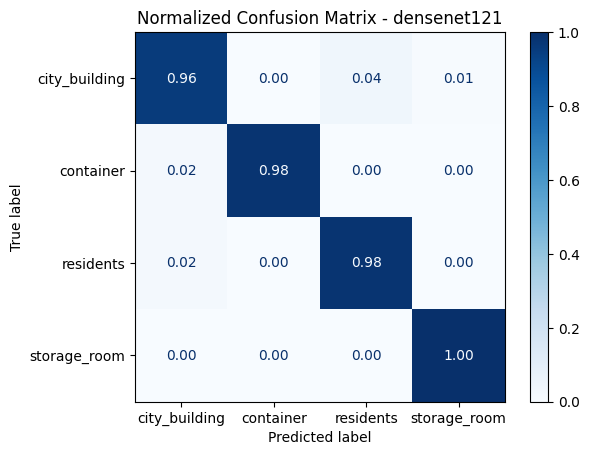

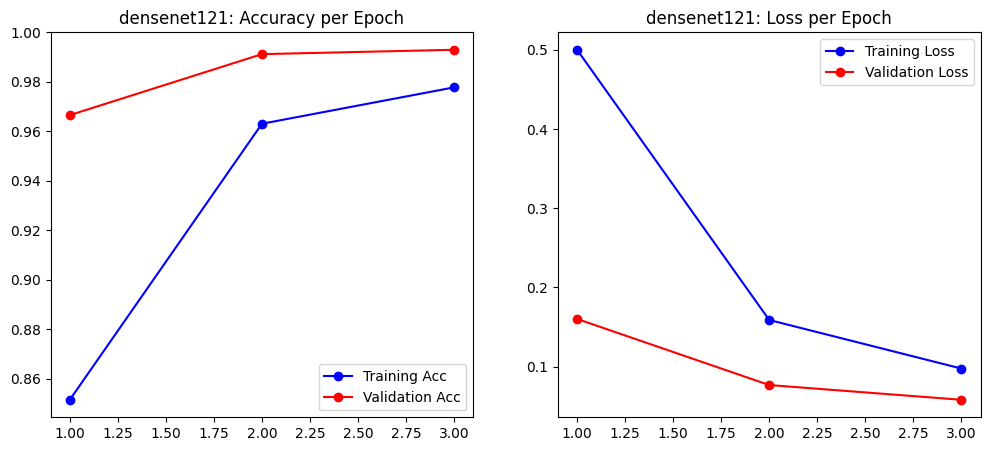

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



🚀 Training model: efficientnet_b0


100%|██████████| 20.5M/20.5M [00:00<00:00, 93.7MB/s]


0
Epoch [1/3] - Loss: 37.7794 - Train Acc: 0.8832 - Val Acc: 0.9718
1
Epoch [2/3] - Loss: 13.0117 - Train Acc: 0.9676 - Val Acc: 0.9771
2
Epoch [3/3] - Loss: 10.5186 - Train Acc: 0.9653 - Val Acc: 0.9859


<ipython-input-21-94ed3bc2314c>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model_name}.pth'))


✅ Test Accuracy (efficientnet_b0): 0.9877


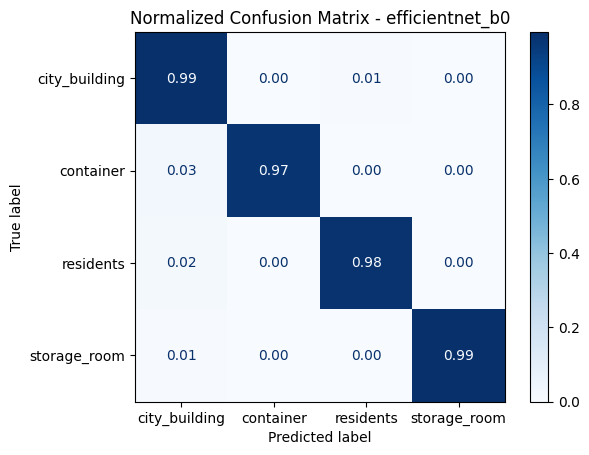

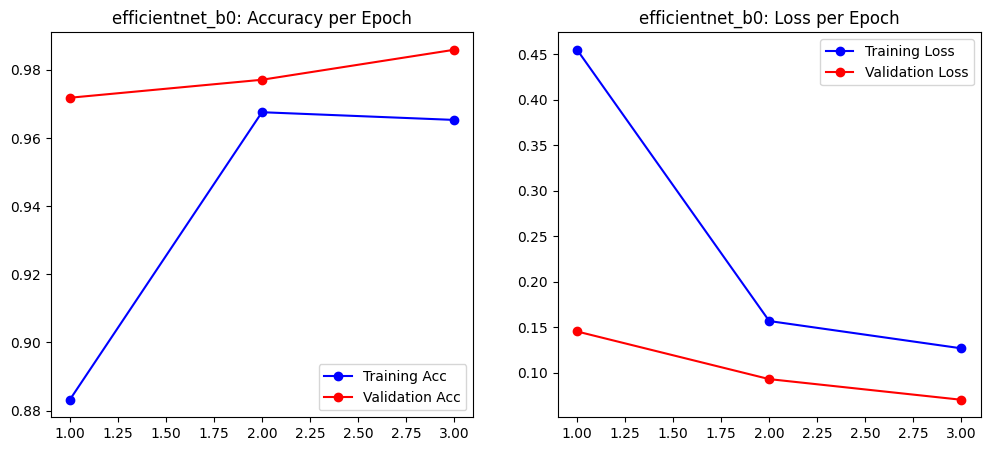


🚀 Training model: resnet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


0
Epoch [1/3] - Loss: 39.7874 - Train Acc: 0.9114 - Val Acc: 0.9613
1
Epoch [2/3] - Loss: 13.0370 - Train Acc: 0.9755 - Val Acc: 0.9789
2
Epoch [3/3] - Loss: 9.0417 - Train Acc: 0.9834 - Val Acc: 0.9824


<ipython-input-21-94ed3bc2314c>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{model_name}.pth'))


✅ Test Accuracy (resnet50): 0.9825


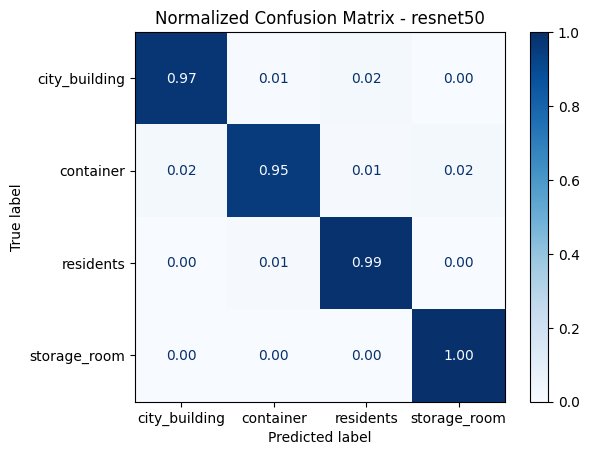

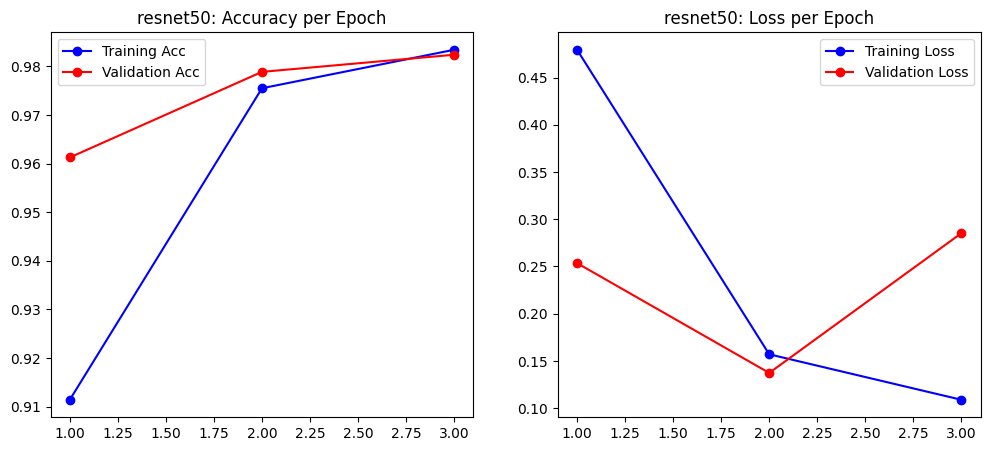

🏅 custom - Final Test Accuracy: 0.9140
🏅 densenet121 - Final Test Accuracy: 0.9807
🏅 efficientnet_b0 - Final Test Accuracy: 0.9877
🏅 resnet50 - Final Test Accuracy: 0.9825


In [ ]:
# 🚀 Compare models
models_to_compare = ['custom', 'densenet121', 'efficientnet_b0','resnet50']
results = {}

for model_name in models_to_compare:
    print(f"\n🚀 Training model: {model_name}")
    if model_name == 'custom':
      model = CNNClassifier(num_classes=len(class_names)).to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)
      train_acc, val_acc, train_loss, val_loss = train_model(model, criterion, optimizer, train_loader, val_loader, model_name, epochs=EPOCHS)
      model.load_state_dict(torch.load(f'best_model_{model_name}.pth'))
      test_acc, _ = evaluate_model(model, test_loader, criterion)
      print(f"✅ Test Accuracy ({model_name}): {test_acc:.4f}")
      analyze_model(model, test_loader, model_name)
      plot_training_analysis(train_acc, val_acc, train_loss, val_loss, model_name)

      results[model_name] = {'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc}
    else:
      model = get_pretrained_model(model_name, num_classes=len(class_names))
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

      train_acc, val_acc, train_loss, val_loss = train_model(model, criterion, optimizer, train_loader, val_loader, model_name, epochs=EPOCHS)
      model.load_state_dict(torch.load(f'best_model_{model_name}.pth'))
      test_acc, _ = evaluate_model(model, test_loader, criterion)
      print(f"✅ Test Accuracy ({model_name}): {test_acc:.4f}")

      analyze_model(model, test_loader, model_name)
      plot_training_analysis(train_acc, val_acc, train_loss, val_loss, model_name)

      results[model_name] = {'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc}

# 🏆 Final Test Accuracy Summary
for model_name, result in results.items():
    print(f"🏅 {model_name} - Final Test Accuracy: {result['test_acc']:.4f}")